In [73]:
%matplotlib notebook
import sys, time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import ipywidgets as widgets
import seaborn as sns
sns.set_style('white')

# 2D Helmholtz equation

The Helmholtz equation is the eigenvalue problem for the Laplace operator. Recall the definition of the Laplace operator in 2D:

$$
\begin{align}
\nabla^2 u &= \frac{\delta^2 u}{\delta x^2} + \frac{\delta^2 u}{\delta y^2}
\end{align}
$$

And recall the definition of eigenvalues $\lambda$ and eigenvectors $\vec{v}$ for a linear transformation $A$:

$$
\begin{align}
A \vec{v} &= \lambda \vec{v}
\end{align}
$$

The Helmholtz equation defines an implicit function $u(x,y)$ that is an *eigenfunction* of the Laplace operator for the eigenvalue $-k^2$. Intuitively, $u$ is a function such that repeatedly applying the Laplace operator only scales the function by $-k^2$.

$$
\begin{align}
\nabla^2 u &= -k^2 u \\
\frac{\delta^2 u}{\delta x^2} + \frac{\delta^2 u}{\delta y^2} &= -k^2 u
\end{align}
$$

Note that, similar to the Laplace and Poisson equations, the Helmholtz equation is time-independent. It describes equilibrium states of a system.

Let's discretize the Helmholtz equation using finite differences.

$$
\begin{align}
\frac{u(x + \Delta x,y) - 2 u(x,y) + u(x - \Delta x,y)}{\Delta x^2} + \frac{u(x,y + \Delta y) - 2 u(x,y) + u(x,y - \Delta y)}{\Delta y^2} &= -k^2 u(x,y) \\
[u(x + \Delta x,y) - 2 u(x,y) + u(x - \Delta x,y)] \Delta y^2 + [u(x,y + \Delta y) - 2 u(x,y) + u(x,y - \Delta y) ] \Delta x^2  &= -k^2 u(x,y) \Delta x^2 \Delta y^2 \\
[u(x + \Delta x,y) + u(x - \Delta x,y)] \Delta y^2 + [u(x,y + \Delta y) + u(x,y - \Delta y) ] \Delta x^2  &= u(x,y) (2 \Delta x^2 + 2 \Delta y^2 -k^2 \Delta x^2 \Delta y^2) \\
\frac{[u(x + \Delta x,y) + u(x - \Delta x,y)] \Delta y^2 + [u(x,y + \Delta y) + u(x,y - \Delta y) ] \Delta x^2}{2 \Delta x^2 + 2 \Delta y^2 -k^2 \Delta x^2 \Delta y^2}  &= u(x,y)
\end{align}
$$

Then convert to the solver computation.

$$
\begin{align}
u_{n,i,j} &= \frac{[u_{n,i+1,j}  + u_{n,i-1,j}] \Delta y^2 + [u_{n,i,j+1} + u_{n,i,j-1} ] \Delta x^2}{2 \Delta x^2 + 2 \Delta y^2 - k^2 \Delta x^2 \Delta y^2} \\
\end{align}
$$

The intuition behind the Laplace operator is it it computes the average difference in values of a function at local spheres around each point from the value at the point. So in the Laplace equation, we are finding functions where the average difference between neighboring values is 0, i.e. the function has a smoothness quality. In the Helmholtz equation, we are finding functions where the average difference between neighboring values is some constant, i.e. there is a constant amount of "turbulence" in the values (is that the proper use of that term?).

The Helmholtz equation as presented in Manduca et al. 2001 and be formed by setting $k^2 = \frac{\rho \omega^2}{\mu}$, where $\mu$ is the shear modulus (elasticity to shear waves), $\rho$ is the density, and $\omega$ is the angular frequency. Then simply rearrange:

$$
\begin{align}
\nabla^2 u &= -k^2 u \\
\nabla^2 u &= -\frac{\rho \omega^2}{\mu} u \\
\mu \nabla^2 u &= -\rho \omega^2 u
\end{align}
$$


<IPython.core.display.Javascript object>


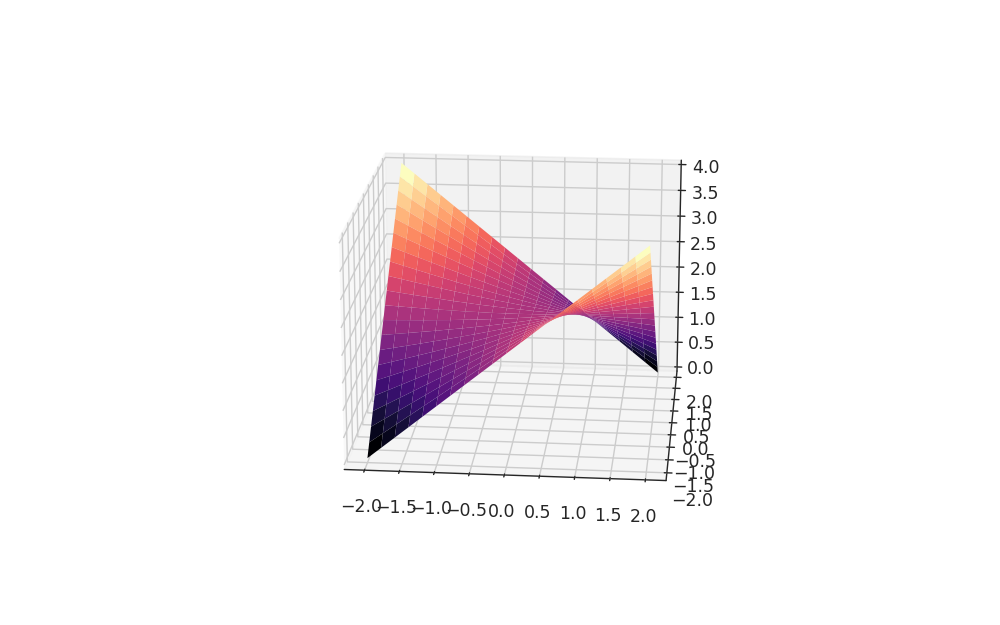

interactive(children=(IntSlider(value=0, description='n', layout=Layout(width='800px'), max=250, step=10), Out…

<function __main__.slider_func(n)>

In [114]:
# 2D Helmholtz equation
n_x = 21
n_y = 21
n_t = 250 # number of iterations

x_size = 4
y_size = 4

dx = x_size / (n_x - 1)
dy = y_size / (n_y - 1)
# no time resolution, just iterations

# eigenvalue of the Laplacian
k = 0

# how often to plot
plot_every = 10

# color by time step
palette = 'magma'
n_colors = int(np.ceil((n_t+1)/plot_every))
colors = sns.color_palette(palette, n_colors)
colors = sns.color_palette(palette, as_cmap=True)

# spatial grid points
x = np.linspace(0, (n_x-1)*dx, n_x) - x_size/2
y = np.linspace(0, (n_y-1)*dy, n_y) - y_size/2
X, Y = np.meshgrid(x, y)

# initial/boundary conditions

n = 0
u = np.abs(np.random.randn(n_t+1, n_x, n_y))
u[n,0,:] = 2+x
u[n,-1,:] = 2-x
u[n,:,0] = 2+y
u[n,:,-1] = 2-y

surfs = []

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

plot_func = lambda x,y,z: ax.plot_surface(x,y,z, cmap=colors, edgecolor='none', antialiased=True)

surf = plot_func(X, Y, u[0].T)
surfs.append((n,surf))

for n in range(1, n_t+1):
    
    u[n,1:-1,1:-1] = (
        dy**2 * (u[n-1,2:,1:-1] + u[n-1,:-2,1:-1]) +
        dx**2 * (u[n-1,1:-1,2:] + u[n-1,1:-1,:-2])
    ) / (2*(dx**2 + dy**2) - k**2 * dx**2 * dy**2)
    
    u[n,0,:] = 2+x
    u[n,-1,:] = 2-x
    u[n,:,0] = 2+y
    u[n,:,-1] = 2-y
    
    if n%plot_every == 0:
        surf = plot_func(X, Y, u[n].T)
        surfs.append((n,surf))

def slider_func(n):
    for i, surf in surfs:
        surf.set_visible(i==n)

widgets.interact(
    slider_func,
    n=widgets.IntSlider(value=0, min=0, max=n_t, step=plot_every, layout=widgets.Layout(width='800px'))
)

In [103]:
help(surfs[0])

Help on Poly3DCollection in module mpl_toolkits.mplot3d.art3d object:

class Poly3DCollection(matplotlib.collections.PolyCollection)
 |  Poly3DCollection(verts, *args, zsort='average', **kwargs)
 |  
 |  A collection of 3D polygons.
 |  
 |  .. note::
 |      **Filling of 3D polygons**
 |  
 |      There is no simple definition of the enclosed surface of a 3D polygon
 |      unless the polygon is planar.
 |  
 |      In practice, Matplotlib fills the 2D projection of the polygon. This
 |      gives a correct filling appearance only for planar polygons. For all
 |      other polygons, you'll find orientations in which the edges of the
 |      polygon intersect in the projection. This will lead to an incorrect
 |      visualization of the 3D area.
 |  
 |      If you need filled areas, it is recommended to create them via
 |      `~mpl_toolkits.mplot3d.axes3d.Axes3D.plot_trisurf`, which creates a
 |      triangulation and thus generates consistent surfaces.
 |  
 |  Method resolution ord

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
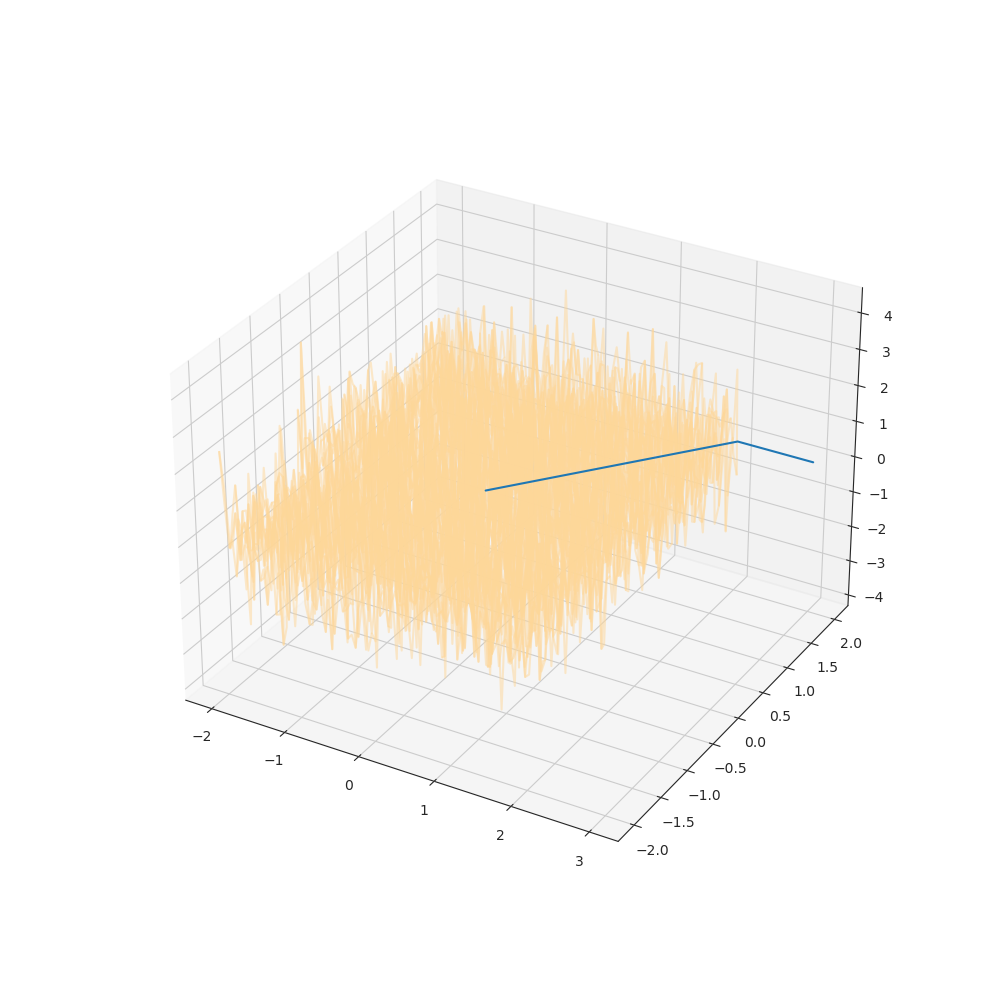